# Time Series Data analysis
what is time series data?
the data which is recored over consistent interval of time/collection of observation of data items which is obtained through repeated measurement


In [6]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay


In [7]:
data=pd.read_csv('Downloads/traffic.csv')

In [8]:
data.head(5)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [9]:
data.tail(5)

,DateTime,Junction,Vehicles,ID
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [10]:
data.info

<bound method DataFrame.info of                   DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
...                    ...       ...       ...          ...
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  2017-06-30 23:00:00         4        12  20170630234

[48120 rows x 4 columns]>

In [11]:
data.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [12]:
data.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [13]:
data['DateTime']=pd.to_datetime(data['DateTime'])

data["Year"]=data['DateTime'].dt.year

data["Month"]=data['DateTime'].dt.month

data["Date_no"]=data['DateTime'].dt.day

data["Hour"]=data['DateTime'].dt.hour

data["Day"]= data['DateTime'].dt.strftime("%A")
data

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


<Axes: xlabel='Date_no', ylabel='Vehicles'>

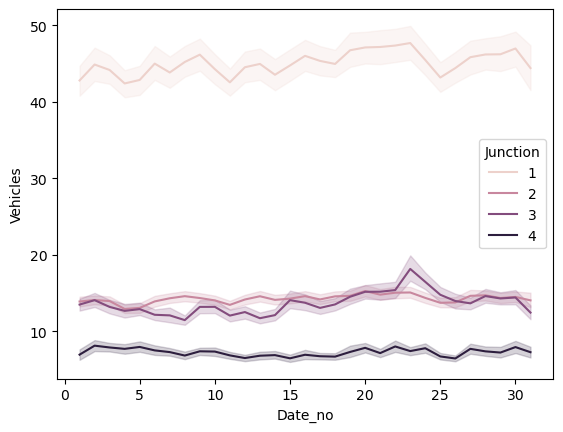

In [14]:
sns.lineplot(x=data['Date_no'],y="Vehicles",data=data,hue='Junction')

In [15]:
data = data[(data['Junction'] == 1)]
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [16]:
df_N, av, std = Normalize(data, "Vehicles")
Diff = Difference(df_N, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N = df_N[24*7:]
df_N.columns = ["Norm"]
df_N["Diff"]= Diff
df = df_N["Diff"].dropna()
df = df.to_frame()
df.head()

,Diff
168,-0.086925
169,0.130387
170,0.043462
171,0.043462
172,0.043462


In [17]:
df.shape

(14424, 1)

In [18]:
def Split_data(df):
    training_size = int(len(df)*0.80)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

df_train, df_test = Split_data(df)

In [20]:
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

X_train, y_train = TnF(df_train)
X_test, y_test = TnF(df_test)
X_train, X_test = FeatureFixShape(X_train, X_test)

In [21]:
X_train, X_test = FeatureFixShape(X_train, X_test)
from sklearn.metrics import mean_absolute_error

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_test, y_test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP


In [22]:
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def MAE_Value(test,predicted):
    mae = mean_absolute_error(test, predicted)
    print("The MAE is {}.".format(mae))
    return mae

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted,label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()
Pred_MLP = MLP_model(X_train,y_train,X_test, y_test)

Epoch 1/50


/Users/surbhianand/Downloads/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1012 - val_loss: 0.0718
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0603 - val_loss: 0.0652
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.0566 - val_loss: 0.0626
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0541 - val_loss: 0.0606
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.0528 - val_loss: 0.0595
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0512 - val_loss: 0.0594
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.0495 - val_loss: 0.0583
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.0502 - val_loss: 0.0580
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.0495 - val_loss: 0.0578
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.0497 - val_loss: 0.0574
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.0475 - val_loss: 0.0568
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.05

The root mean squared error is 0.23826616863131592.
The MAE is 0.17113287903073887.


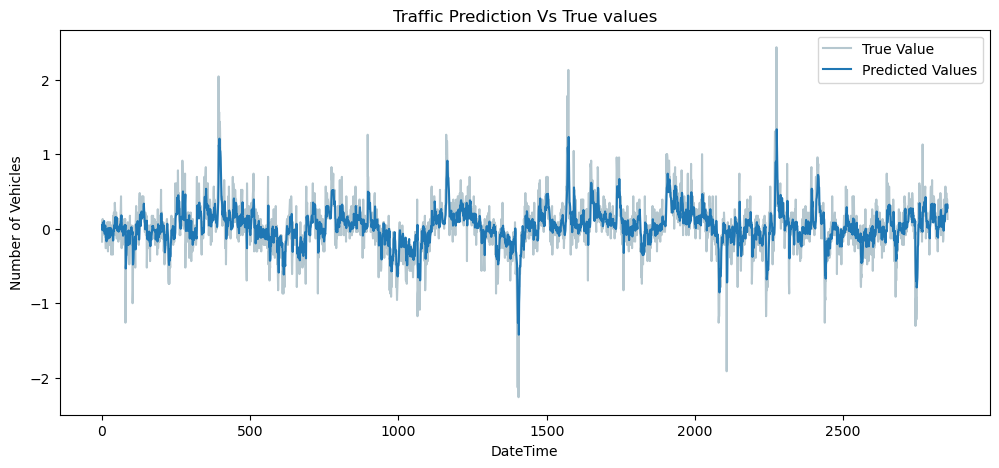

In [23]:
colors = ["#6D91A1","#74B3CE1","#536D7A","#3E535B"]
RMSE_MLP = RMSE_Value(y_test, Pred_MLP)
MAE_MLP = MAE_Value(y_test, Pred_MLP)
PredictionsPlot(y_test, Pred_MLP, 0)


In [24]:
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning.
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU


In [25]:
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The LSTM model 
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

In [26]:
Pred_GRU = GRU_model(X_train,y_train,X_test,y_test)

Epoch 1/50


/Users/surbhianand/Downloads/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0649 - val_loss: 0.0619
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0497 - val_loss: 0.0605
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0477 - val_loss: 0.0590
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0475 - val_loss: 0.0586
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0462 - val_loss: 0.0577
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0478 - val_loss: 0.0579
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0464 - val_loss: 0.0569
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0461 - val_loss: 0.0576
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0463 - val_loss: 0.0565
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0456 - val_loss: 0.0572
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0445 - val_loss: 0.0566
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0426 - val_l

In [27]:
Pred_LSTM = LSTM_model(X_train,y_train,X_test, y_test)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0785 - val_loss: 0.0800
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0636 - val_loss: 0.0757
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0556 - val_loss: 0.0729
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0547 - val_loss: 0.0709
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0546 - val_loss: 0.0693
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0542 - val_loss: 0.0685
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0536 - val_loss: 0.0671
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0516 - val_loss: 0.0659
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0529 - val_loss: 0.0648
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0503 - val_loss: 0.0642
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0513 - val_loss: 0.0637
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0

The root mean squared error is 0.23775228794798703.
The MAE is 0.1714745234489848.


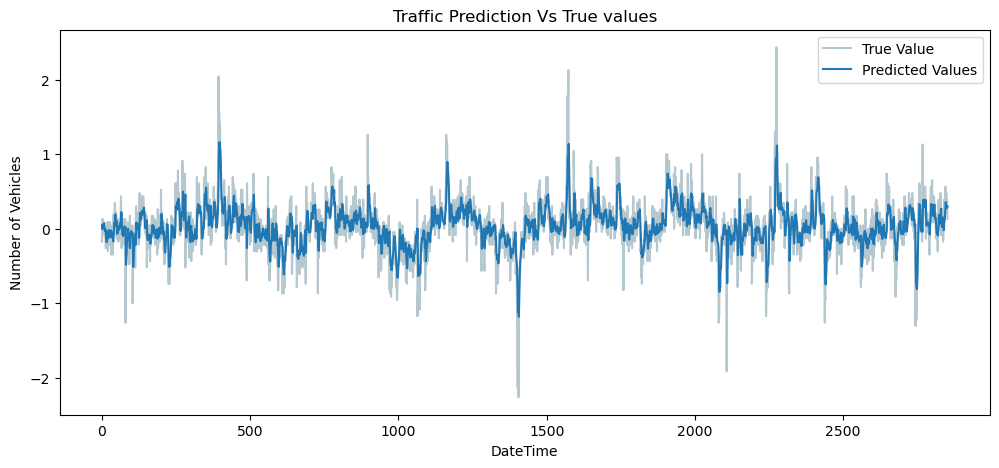

In [28]:
RMSE_LSTM = RMSE_Value(y_test, Pred_LSTM)
MAE_LSTM = MAE_Value(y_test, Pred_LSTM)
PredictionsPlot(y_test, Pred_LSTM, 0)